# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [04:27<00:00, 224File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

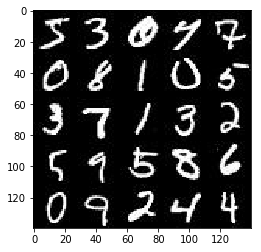

In [117]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

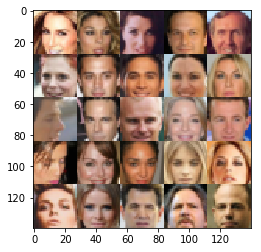

In [118]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [119]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [120]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """    
    
    real_input_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim] )
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [164]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        # Do not apply batch normalization to input layer
        # should i add kernel_initializer=tf.contrib.layers.xavier_initializer()?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape) # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [165]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse_var = not is_train
    
    with tf.variable_scope('generator', reuse=reuse_var):        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        #print(x3.shape)
        
        # Output layer
        # Do not apply batch normalization to output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.shape)
        # 28x28xout_channel_dim         
        
        out = tf.tanh(logits)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [166]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    real_labels = tf.ones_like(d_model_real) * 0.9 #smoothing        
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [167]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [168]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [169]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                batch_images = batch_images * 2.0 #this is done since range of data is -0.5 to 0.5 and we want -1 to 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, 
                                               z_input: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images,
                                               z_input: batch_z,
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({ real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8768... Generator Loss: 0.1232
Epoch 1/2... Discriminator Loss: 4.0964... Generator Loss: 0.0347
Epoch 1/2... Discriminator Loss: 4.0278... Generator Loss: 0.0347
Epoch 1/2... Discriminator Loss: 2.7656... Generator Loss: 0.1112
Epoch 1/2... Discriminator Loss: 2.3459... Generator Loss: 0.1860
Epoch 1/2... Discriminator Loss: 1.9413... Generator Loss: 0.2934
Epoch 1/2... Discriminator Loss: 2.4835... Generator Loss: 0.1497
Epoch 1/2... Discriminator Loss: 2.2536... Generator Loss: 0.2509
Epoch 1/2... Discriminator Loss: 1.9402... Generator Loss: 0.3418
Epoch 1/2... Discriminator Loss: 1.7363... Generator Loss: 0.3427


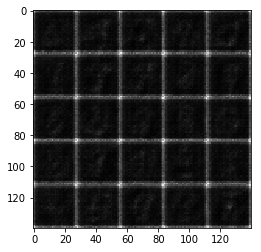

Epoch 1/2... Discriminator Loss: 1.9290... Generator Loss: 0.2594
Epoch 1/2... Discriminator Loss: 1.7813... Generator Loss: 0.3202
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.5534... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.5482
Epoch 1/2... Discriminator Loss: 1.6555... Generator Loss: 0.3467
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 1.5881


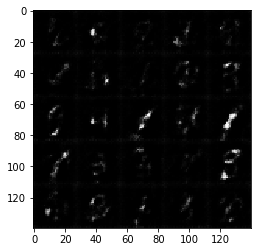

Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.1709
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.3959
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5331
Epoch 1/2... Discriminator Loss: 1.6177... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 1.2790
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.6548... Generator Loss: 0.3424


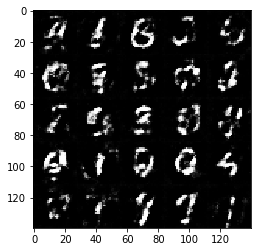

Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 2.5273
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 1.6385
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 1.2837
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.5211
Epoch 1/2... Discriminator Loss: 2.2001... Generator Loss: 0.2133


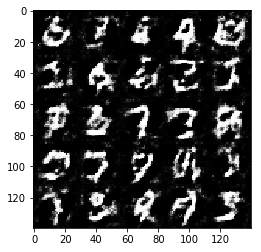

Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 1.4488
Epoch 1/2... Discriminator Loss: 1.8281... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.0577... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 2.3138... Generator Loss: 0.1807
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.6384


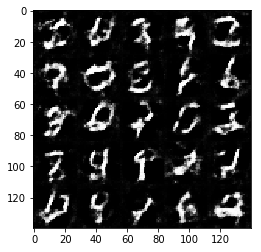

Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.5697
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 2.2901
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 1.5651
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.7721


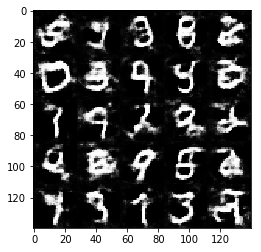

Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 0.9878... Generator Loss: 1.1272
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.6037
Epoch 1/2... Discriminator Loss: 1.9227... Generator Loss: 0.2944
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 2.0319
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.9192
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.7295


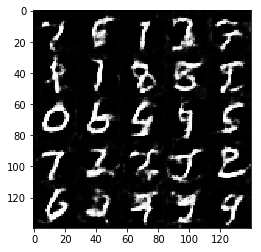

Epoch 1/2... Discriminator Loss: 1.6273... Generator Loss: 0.3504
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.4306
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.8714
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 1.9570
Epoch 1/2... Discriminator Loss: 0.9919... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: 1.6176... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 1.7575... Generator Loss: 0.3118


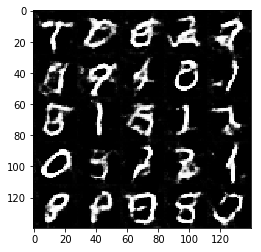

Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.7722... Generator Loss: 0.3515
Epoch 1/2... Discriminator Loss: 1.8271... Generator Loss: 0.3234
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.5986


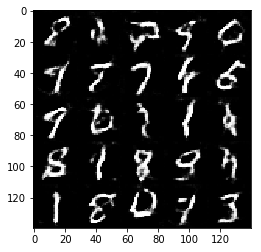

Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 1.9712... Generator Loss: 0.2479
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 1.7446
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5180


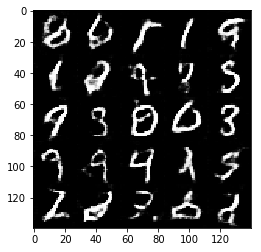

Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.6013
Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 1.3065
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.2816
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.4827
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.8683
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 0.9531


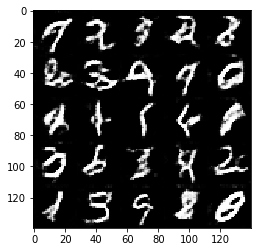

Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 2.1123
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.6512... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.0648
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 1.3135


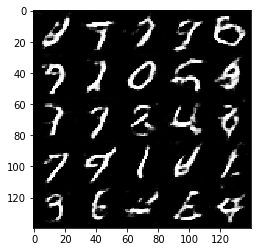

Epoch 1/2... Discriminator Loss: 1.5749... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 2.7234... Generator Loss: 0.1730
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.7791
Epoch 1/2... Discriminator Loss: 1.6911... Generator Loss: 0.3535
Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8405


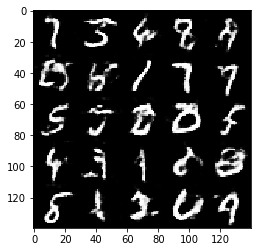

Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.6991
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 2.0992
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 1.2328
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 1.0915


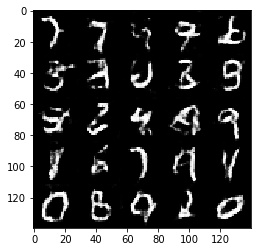

Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.7044
Epoch 1/2... Discriminator Loss: 1.6332... Generator Loss: 0.4127
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.5146
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.4206
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 0.9191


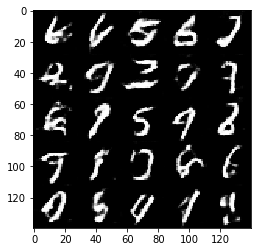

Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 2.7151... Generator Loss: 0.1654
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 0.9713
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.6240
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 1.7815
Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.5633


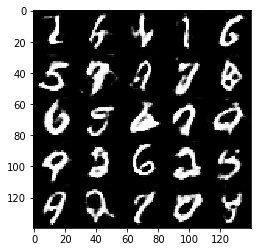

Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 1.3485
Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 1.5145
Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.6025
Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 0.5581


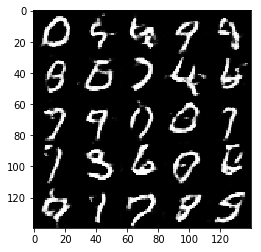

Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.1785
Epoch 1/2... Discriminator Loss: 1.9866... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 1.6389
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.4582
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 2.4939
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.0017
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.0745


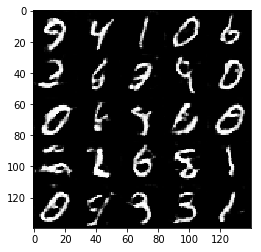

Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 2.1964
Epoch 1/2... Discriminator Loss: 0.8754... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 1.6719... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.6563
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 1.8143... Generator Loss: 0.2865
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.7358
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.5431
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.6507... Generator Loss: 0.3857
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.8557
Epoch 2/2.

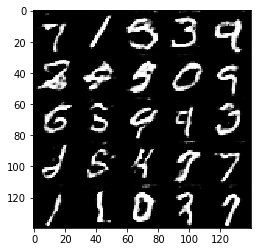

Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.7475
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 1.4318


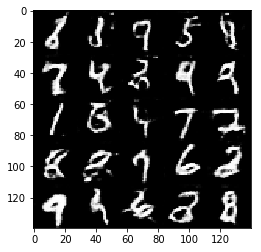

Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.5811
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.5723... Generator Loss: 0.4788
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.7069... Generator Loss: 3.1794


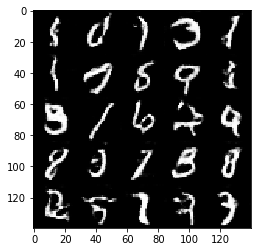

Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 2.0487... Generator Loss: 0.2705
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.7563


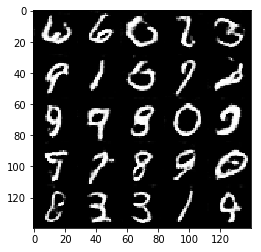

Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.4720
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 2.0824
Epoch 2/2... Discriminator Loss: 0.8010... Generator Loss: 1.3618
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.4863
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 1.3676
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.2555
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 1.0002
Epoch 2/2... Discriminator Loss: 1.7550... Generator Loss: 0.3491


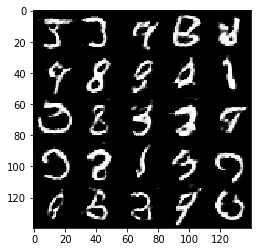

Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.7273
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 2.2334... Generator Loss: 0.2451
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 2.0679
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 2.1554
Epoch 2/2... Discriminator Loss: 1.5586... Generator Loss: 0.4233
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.5826


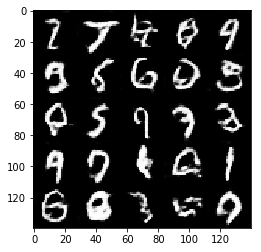

Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.5633
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.7523
Epoch 2/2... Discriminator Loss: 0.8502... Generator Loss: 2.2318
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 2.2503
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 1.6287... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.6687
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.2666


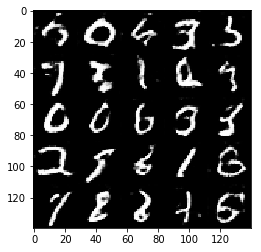

Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.4520
Epoch 2/2... Discriminator Loss: 0.6728... Generator Loss: 1.5570
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 2.0930
Epoch 2/2... Discriminator Loss: 0.6688... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.6356... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.7325
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.5489


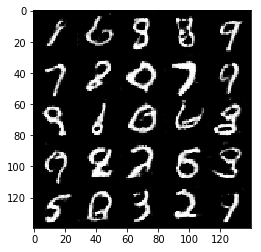

Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.7054
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 1.4963
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.4742
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 2.0408
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.5478


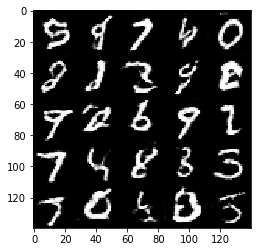

Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.7350
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.1848
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.8413


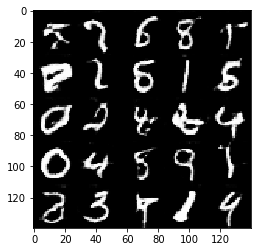

Epoch 2/2... Discriminator Loss: 1.6164... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.1524
Epoch 2/2... Discriminator Loss: 2.0836... Generator Loss: 0.2581
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 2.1281
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 2.9973
Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.7514
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.6292


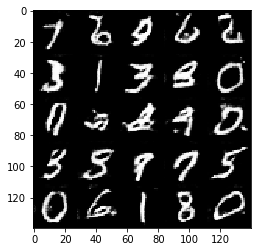

Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.8033
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.2102
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.6845... Generator Loss: 0.3730
Epoch 2/2... Discriminator Loss: 2.3531... Generator Loss: 0.2040
Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.2488


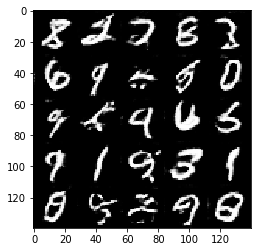

Epoch 2/2... Discriminator Loss: 0.6796... Generator Loss: 1.4363
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 3.0407
Epoch 2/2... Discriminator Loss: 0.6599... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.5642
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.3511
Epoch 2/2... Discriminator Loss: 0.7607... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 0.6042... Generator Loss: 1.7902
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.2901
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9396
Epoch 2/2... Discriminator Loss: 2.0433... Generator Loss: 3.2649


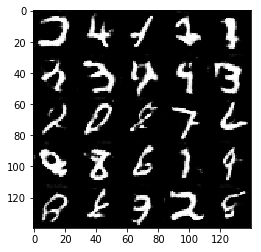

Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 1.4015
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 1.7281... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 0.9197... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.7703
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 2.1400
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.6692


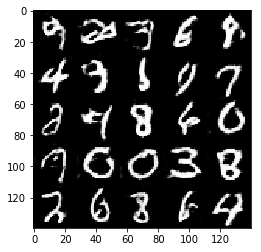

Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 2.2266
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.6363
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 2.4781
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.8921
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.1864
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.3119
Epoch 2/2... Discriminator Loss: 1.5320... Generator Loss: 0.4676


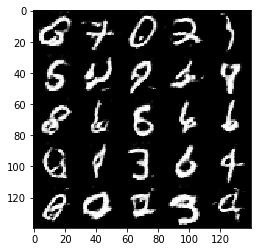

Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 2.2527
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.0836
Epoch 2/2... Discriminator Loss: 0.7920... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 2.0090
Epoch 2/2... Discriminator Loss: 2.1363... Generator Loss: 0.2230
Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 0.7208... Generator Loss: 1.4823


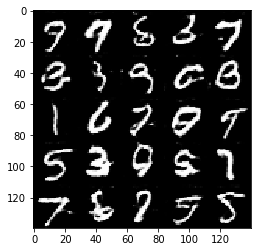

Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 2.1869
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.7412
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 2.4587
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.9236
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.3148
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.7775


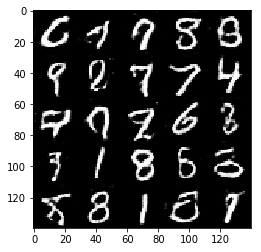

Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 1.7937
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 2.3655
Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 1.9665
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.9182
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 1.6141... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.6374
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.5375
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 2.0901


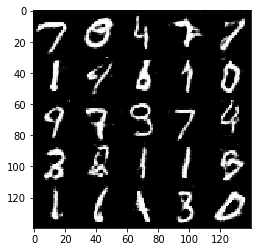

Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.5175
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 2.0906
Epoch 2/2... Discriminator Loss: 0.7714... Generator Loss: 1.6928
Epoch 2/2... Discriminator Loss: 1.7791... Generator Loss: 0.3804
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.6078


In [170]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 4.1714
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 4.8375
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 1.7803... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 2.1568... Generator Loss: 0.2443
Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.4905


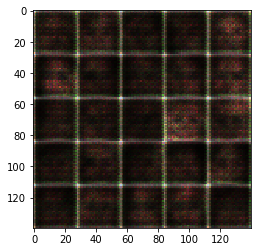

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 2.9134
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 4.1529
Epoch 1/1... Discriminator Loss: 1.9972... Generator Loss: 4.1172
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 2.5976
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 3.3734
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.3455


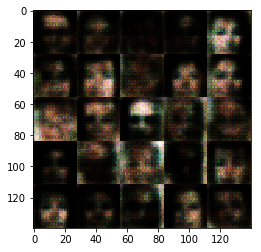

Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 2.5183
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 2.2227... Generator Loss: 0.1940
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 2.3657
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 3.0438
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 3.0006
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 3.3693


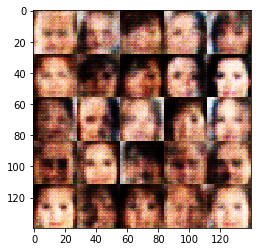

Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 3.3102
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.9076
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5019
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.8967
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 3.5002
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 4.7498
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 4.6149
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0511


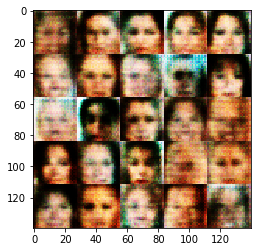

Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.8869... Generator Loss: 0.2851
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 2.7968
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 5.1410
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.5973
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.6695
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.4756


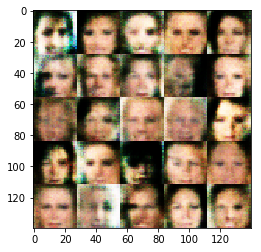

Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 4.0794
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.8315
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 0.3267
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 3.1967
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 4.1766
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 2.4886
Epoch 1/1... Discriminator Loss: 1.9469... Generator Loss: 2.8051


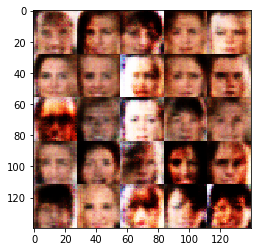

Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.1636
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.5104
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.6032
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.9143
Epoch 1/1... Discriminator Loss: 0.4112... Generator Loss: 4.7558
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.8593
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.9662


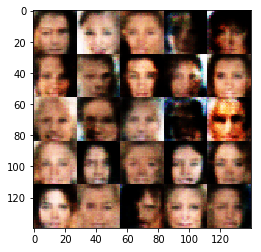

Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.6056
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 0.7472... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 0.9998


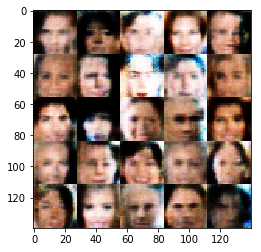

Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.3100
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 2.0704
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 1.7487
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 3.0252
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 2.5321
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.5930


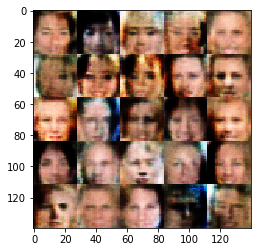

Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 3.6133
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 3.3268
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 2.6165
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 3.7165
Epoch 1/1... Discriminator Loss: 2.3464... Generator Loss: 0.1838
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.8870
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.5984
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 3.9917


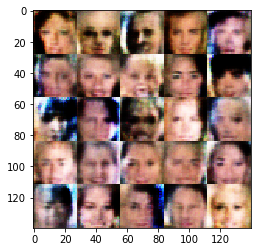

Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 2.9900
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 3.9209
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 5.7269
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 4.0000
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.2352
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 2.4420
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 1.7214


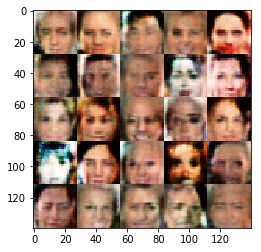

Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 2.2784... Generator Loss: 2.9724
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 2.2060
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.4598
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 2.5830
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 5.2326
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.0825


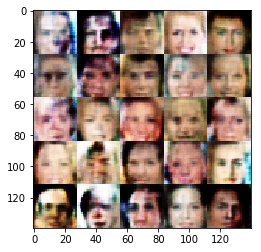

Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.2167
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.0124
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 3.7880


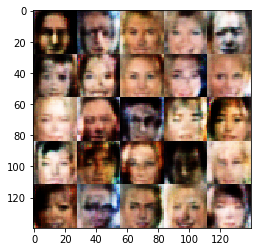

Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 4.2289
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 4.1670
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.2785
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 2.7738
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 3.9159
Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 3.4500
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.9564
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 1.6744


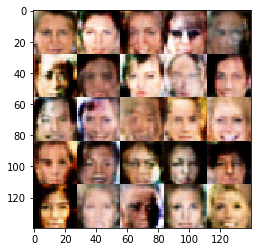

Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.8778
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 2.8975
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 0.3956
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.5942
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 2.1128
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.1589
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 2.2366


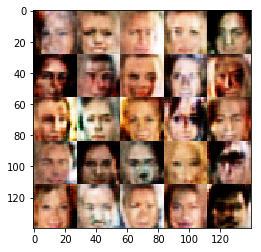

Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 1.7216
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.5625
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 4.6808
Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 4.1123
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 2.6351
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.2993
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 2.6339


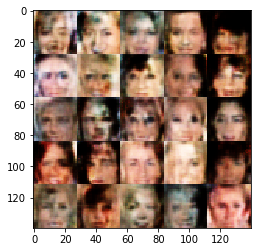

Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 2.9347
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 1.9732
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.2832
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 2.2345
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.9285
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.1879


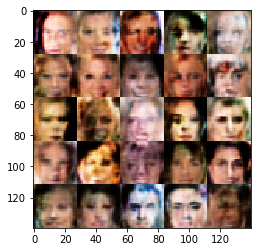

Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 2.0483
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 2.6568
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 2.5652
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 2.5491
Epoch 1/1... Discriminator Loss: 2.4194... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 2.1505
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.3563


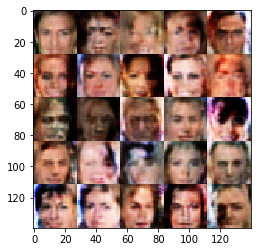

Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 2.7059
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 3.1876
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 1.9581
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.2606
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 3.4408
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.0313
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 2.3336


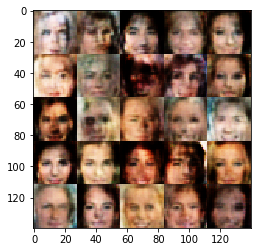

Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 2.7134
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.5565... Generator Loss: 3.6261
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 4.2918
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 2.1842


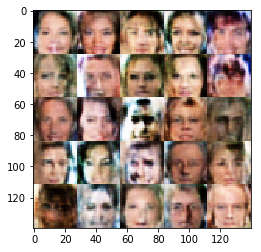

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.7630... Generator Loss: 0.3075
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 3.2758
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.1804
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.4686


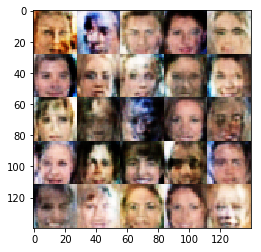

Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 3.7683
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 2.1231
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.0312
Epoch 1/1... Discriminator Loss: 2.0680... Generator Loss: 2.6639
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 2.1737
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.7302


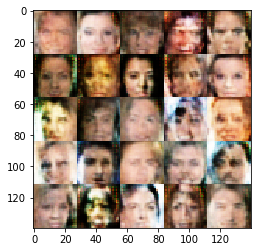

Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.3088
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.6213... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.0419
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9476


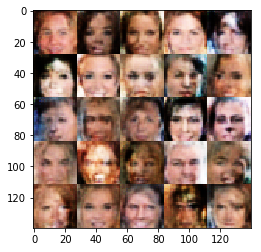

Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.2457
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.2308
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 3.0085
Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.8001
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.7799
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6277


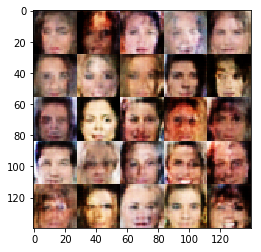

Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.9194
Epoch 1/1... Discriminator Loss: 0.7252... Generator Loss: 2.1651
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.2278


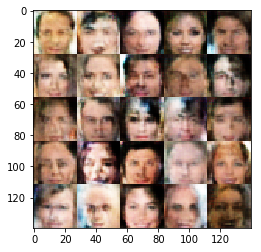

Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.8049
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.4240
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.3314
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.6499


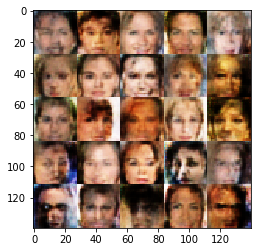

Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 2.6476
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 2.3942... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.9980
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.9750


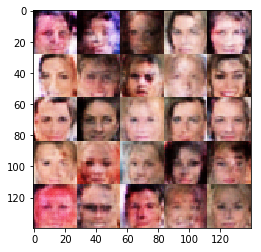

Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.0534
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.7485... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.1074
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.7454


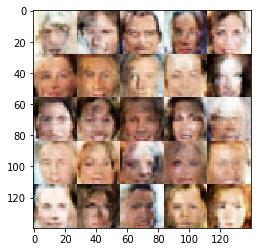

Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 2.4580
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.7231
Epoch 1/1... Discriminator Loss: 2.3246... Generator Loss: 2.8627
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 0.6331... Generator Loss: 2.6150
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 3.0880
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.8315
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 2.0810
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.3136


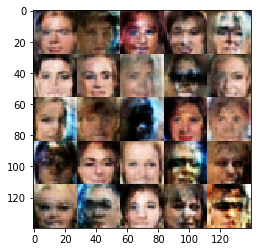

Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.0241
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 1.8892
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.4767
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.9800
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 1.5964


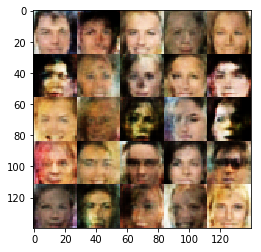

Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 2.5351
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.1406
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.7859


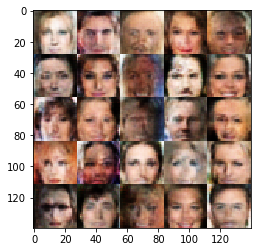

Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.6645
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.8062


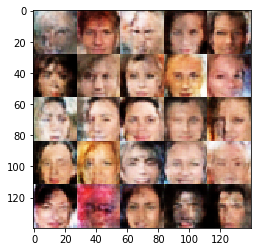

Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.4099
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 2.0990
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.7079


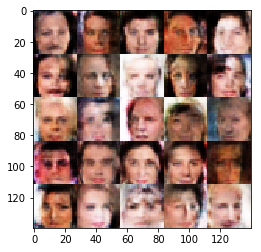

Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 0.2649
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 2.6932
Epoch 1/1... Discriminator Loss: 1.8581... Generator Loss: 0.2874


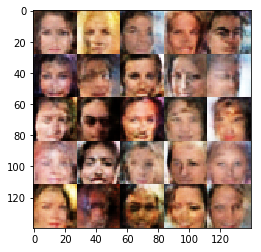

Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.9358


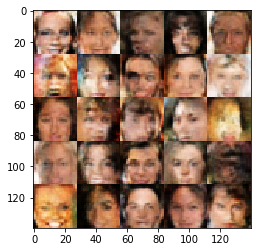

Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 2.3362
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.6760... Generator Loss: 0.3376
Epoch 1/1... Discriminator Loss: 1.7906... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.8071


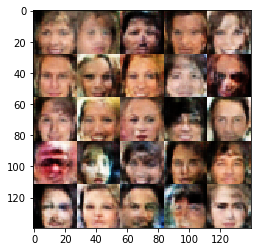

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 2.3698
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.3279
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 2.1086
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6465


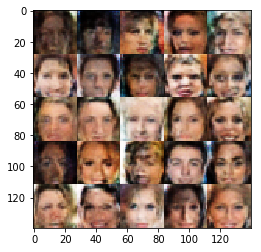

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.5024
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.9183... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 3.0231


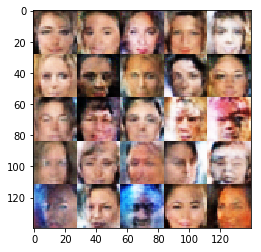

Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.9940
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.8645... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 0.3711
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.9621


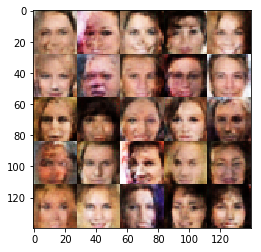

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.7539
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 2.1759... Generator Loss: 0.2120


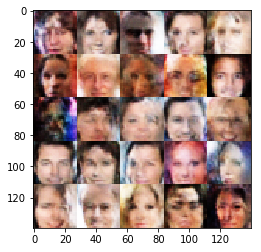

Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 2.0138
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 0.3019
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.6485


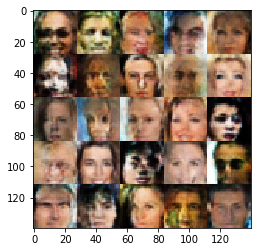

Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 2.5008
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 2.3308


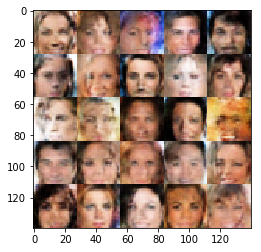

Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 2.3781... Generator Loss: 2.8698
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 0.6438... Generator Loss: 1.8276
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.4924
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.6184
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.6940


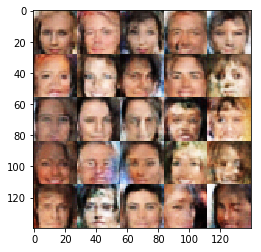

Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.2760
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 3.4641
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.1466
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.5162


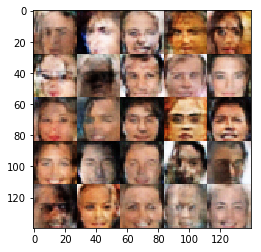

Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.8520... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.9428
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.8909
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.4197
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.4849


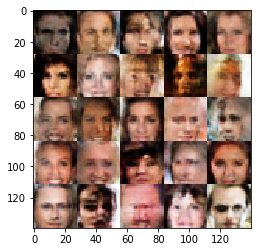

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 2.2536
Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.3237
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 2.1567
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.5469
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.0463


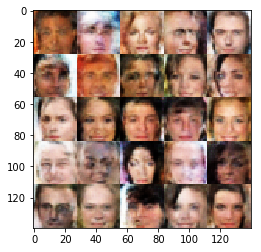

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.9974
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.6749... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.8725... Generator Loss: 0.2803
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.2746


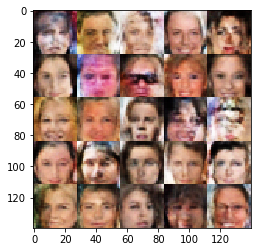

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3523
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.8726


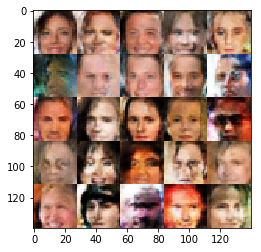

Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.4757
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.9028... Generator Loss: 0.2583
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.4149


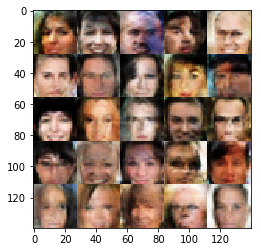

Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.4109
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.3839
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.7933


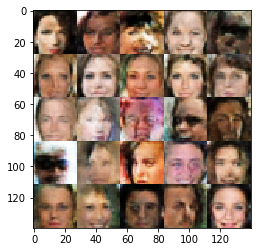

Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.0642


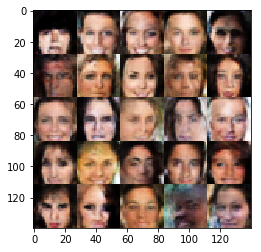

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.9088
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 2.2706
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.4158


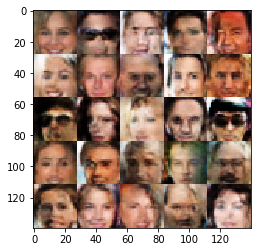

Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.7058... Generator Loss: 0.3268
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8666


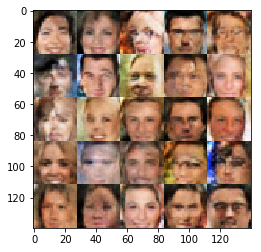

Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.6717
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.7230... Generator Loss: 0.3233
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.1353


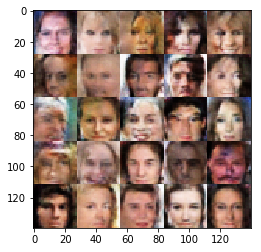

Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.5378
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.8557... Generator Loss: 0.2864
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 2.0244... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.4053


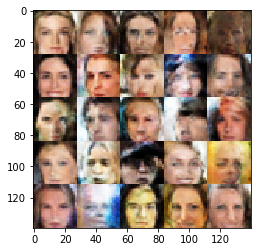

Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.2920
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.4222
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.5604


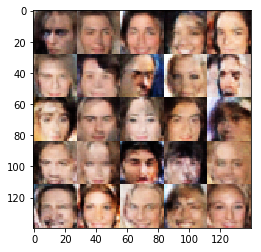

Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.2840
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 2.0165
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.3633
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4017


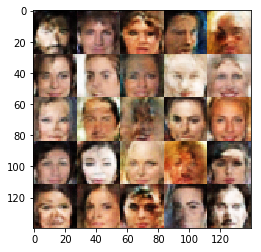

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 2.3576... Generator Loss: 0.1631
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 2.1497
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 1.7995... Generator Loss: 0.3089


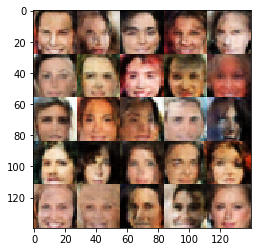

Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.7330
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 1.7317
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.2340


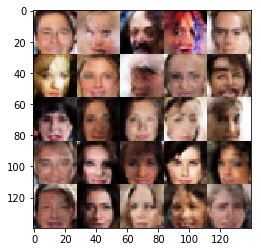

Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 2.1080... Generator Loss: 0.2145
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.0070


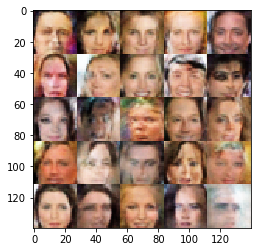

Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 0.3357
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.8090
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.0691


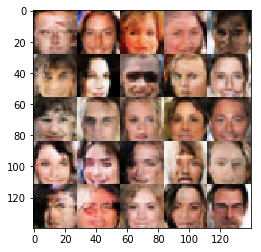

Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 2.0696
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 0.3244


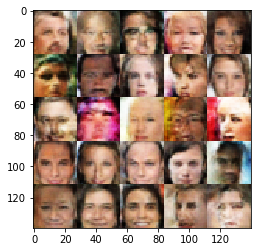

Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.3906
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.2467


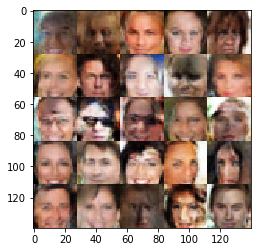

Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 2.2008
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6317


In [171]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.